# DAT 19: Homework 4 Assignment - SVMs, Trees, RF

## Instructions

The goal of this homework is to review and bring together what we have learned about Support Vector Machines, Decision Trees, Random Forests, and ensembles. 

Please do all your analysis to answer the questions below in this Jupyter notebook. Show your work.

**Please submit your completed notebook by 6:30PM on Wednesday, February 17.**

## About the Data

Use the cancer_uci.csv dataset in the Data directory of our course repo. This is the [Breast Cancer Wisconsin](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)) dataset from the UCI ML Repository.

## Homework Assignment

**1) Load the data and check for balance between the two classes. If the ratio is less than 60/40 rebalance the classes to 50/50. We've provided some help here to get you started.**

In [18]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn import cross_validation
from bokeh.plotting import figure,show,output_notebook
from bokeh.models import Range1d
output_notebook()
%matplotlib inline
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',60)

Loading BokehJS ...

In [2]:
canc = pd.read_csv("../data/cancer_uci.csv", index_col=0)
canc.head()
canc.Class.value_counts()
# What are the frequencies of each class?

Benign       458
Malignant    241
Name: Class, dtype: int64

We have imbalanced classes so we need to decide if we want to undersample, and take only 241 values from the Benign category, or oversample, and artificially inflate the volume of malignant data. First, let's convert to binary 1,0 for classification.

In [3]:
canc.Class = canc.Class.map({'Benign':0,'Malignant':1})
canc.Class.value_counts()

0    458
1    241
Name: Class, dtype: int64

To undersample, we would throw away almost half of our benign examples, which would greatly alter our dataset and we don't want to lose that much info. So let's oversample! Here is a pattern for how to oversample:

In [4]:
# Separate your two classes:
mal_example = canc[canc.Class == 1]
benign_example = canc[canc.Class == 0]

# Oversample the malignant class to have a 50/50 ratio:
mal_over_example = mal_example.sample(458,replace=True)

# Recombine the two frames:
over_sample = pd.concat([mal_over_example,benign_example])

# Sanity check the length:
print len(over_sample)

916


**2) Are the features normalized? If not, use the scikit-learn standard scaler to normalize them.**

In [5]:
# filter out '?', cast as numpy array to determine mean, and then change to append mean
new_bare = []
for bare in over_sample['Bare_Nuclei']:
    try:
        new_bare.append(int(bare))
    except:
        new_bare.append(3.544656)

In [6]:
over_sample['Bare_Nuclei'] = new_bare

In [7]:
# cast all to float
cancer_data = over_sample.astype(float)

In [8]:
features = cancer_data.drop('Class')
target = cancer_data.Class

In [9]:
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(features)

**3) Train a linear SVM, using the cross validated accuracy as the score (use the scikit-learn method).**

In [88]:
#your code here
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    features, target, test_size=0.2, random_state=0)

In [89]:
from sklearn import svm
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
score = cross_validation.cross_val_score(svm_model,
        X_test, y_test, cv=10)
score

array([ 0.68421053,  0.78947368,  0.63157895,  0.57894737,  0.63157895,
        0.66666667,  0.55555556,  0.66666667,  0.66666667,  0.64705882])

In [91]:
predictions = svm_model.predict(X_test)

**4) Display the confusion matrix, classification report, and AUC.**

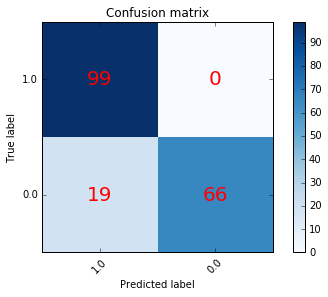

In [92]:
#your code here
from sklearn.metrics import confusion_matrix as confusion_matrix
confusion = confusion_matrix(predictions, y_test)
import numpy as np
import matplotlib.pyplot as plt
 
# Utility method to draw a confusion matrix
def plot_confusion_matrix(cm, target, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target.unique()))
    plt.xticks(tick_marks, target.unique(), rotation=45)
    plt.yticks(tick_marks, target.unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for y in [0,1]:
        for x in [0,1]:
            plt.text(x, y, '%.0f' % cm[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='red',
                     fontsize=20
                     )
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, target)

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['Benign','Malignant']))

             precision    recall  f1-score   support

     Benign       0.84      1.00      0.91        99
  Malignant       1.00      0.78      0.87        85

avg / total       0.91      0.90      0.89       184



In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

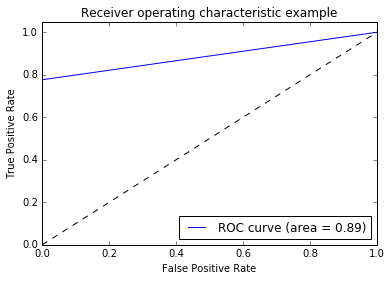

In [95]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**5) Repeat steps 2 through 4 using a Decision Tree model. Are the results better or worse than the SVM?**

In [96]:
#your code here
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    features, target, test_size=0.2, random_state=0)

tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [97]:
score = cross_validation.cross_val_score(tree_model,
        X_test, y_test, cv=10)
score

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [98]:
predictions = tree_model.predict(X_test)
predictions

array([ 1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

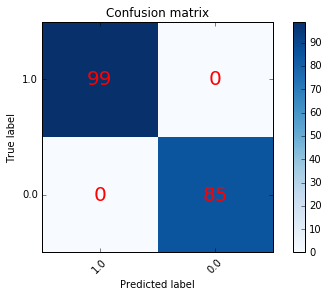

In [99]:
confusion = confusion_matrix(predictions, y_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, target)

In [100]:
print(classification_report(y_test, predictions, target_names=['Benign','Malignant']))

             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00        99
  Malignant       1.00      1.00      1.00        85

avg / total       1.00      1.00      1.00       184



In [101]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

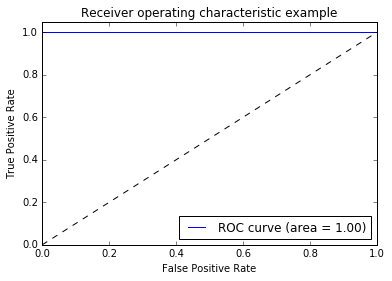

In [102]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**6) Repeat steps 2 through 4 using a Random Forest model. Are the results better or worse than the SVM?**

In [103]:
#your code here
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    features, target, test_size=0.2, random_state=0)

forest_model = RandomForestClassifier(random_state=0)
forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [104]:
score = cross_validation.cross_val_score(forest_model,
        X_test, y_test, cv=10)
score

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.94444444,  1.        ,  1.        ,  1.        ,  1.        ])

In [105]:
predictions = forest_model.predict(X_test)
predictions

array([ 1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

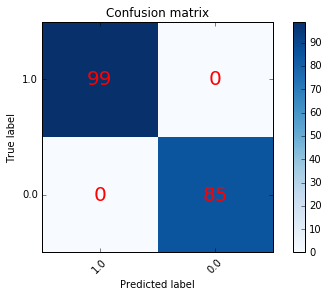

In [106]:
confusion = confusion_matrix(predictions, y_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, target)

In [107]:
print(classification_report(y_test, predictions, target_names=['Benign','Malignant']))

             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00        99
  Malignant       1.00      1.00      1.00        85

avg / total       1.00      1.00      1.00       184



In [108]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

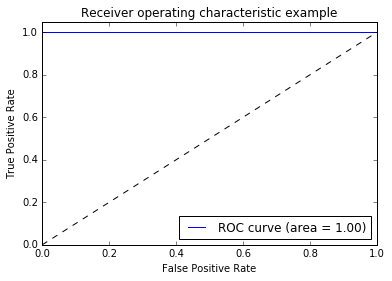

In [109]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Extra Credit Questions
**The following questions are strongly encouraged, but not required for this homework assignment.**

**7) Combine the SVM and the Decision Tree model using the [Voting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html). Are the results better than either of these base classifiers alone?**

In [110]:
#your code here
from sklearn.ensemble import VotingClassifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    features, target, test_size=0.2, random_state=0)
voting_model = VotingClassifier(estimators=[('dt', tree_model),
                                            ('svm', svm_model)],
                                voting='soft')

In [111]:
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')), ('svm', ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         voting='soft', weights=None)

In [113]:
score = cross_validation.cross_val_score(voting_model,
        X_test, y_test, cv=10)
score

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [114]:
predictions = voting_model.predict(X_test)
predictions

array([ 1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

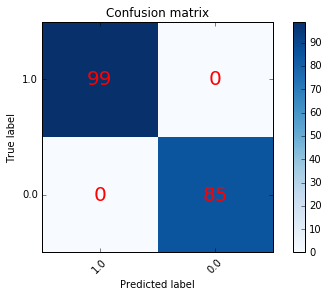

In [115]:
confusion = confusion_matrix(predictions, y_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, target)

In [116]:
print(classification_report(y_test, predictions, target_names=['Benign','Malignant']))

             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00        99
  Malignant       1.00      1.00      1.00        85

avg / total       1.00      1.00      1.00       184



In [117]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

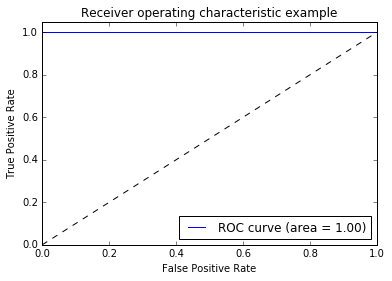

In [118]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**8) Train an SVM using the RBF kernel. Is this model better or worse?**

In [ ]:
#your code here